In [12]:
import numpy as np
import pandas as pd
#pd.options.display.max_columns = None
import matplotlib.pyplot as plt
%matplotlib inline
from torchtext.data import Field, TabularDataset, Iterator, Pipeline
import torch
from net.AttentionLSTM import AttentionLSTM
import os, sys
import numpy as np
from torchtext.vocab import GloVe

In [3]:
# Class meant to replace the 'obj'
class Options():
    def __init__(self):
        self.vocab_size = 20427
        self.embedding_dim = 25
        #self.word_embeddings = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.hidden_size = 64
        self.meta_hidden_size = 16
        self.meta_dim = 9
        self.total_hidden_size = 8
        self.device = 'cpu' #'cuda:0'
        self.output_size = 3
        self.Glove_name = 'twitter.27B'
        self.fix_length = None
        self.attention_size = 64

        troll_root = os.path.join(os.environ['REPOROOT'], 'ProjectTroll-master')
        sys.path.insert(0, troll_root)
        glove_path = os.path.join(troll_root, '.vector_cache')
        self.data_path = os.path.join(troll_root, 'mydata')    

        tokenize = lambda x: x.split()
        TEXT = Field(sequential=True,
                     tokenize=tokenize,
                     lower=True,
                     batch_first=True,
                     fix_length=self.fix_length)

        VARIABLE = Field(sequential=False,
              dtype=torch.float,
              batch_first=True,
              use_vocab=False)

        LABEL = Field(sequential=False,
                      dtype=torch.float,
                      batch_first=True,
                      use_vocab=False)
        train_csv = 'train1.csv'
        #test_csv = 'test1.csv'

        fields = [#('id', None),
          ('content', TEXT),
          ('avg_followers',VARIABLE),
          ('avg_following', VARIABLE),
          ('avg_left', VARIABLE),
          ('avg_news', VARIABLE),
          ('avg_right', VARIABLE),
          ('time', VARIABLE),
          ('baseline_pred_left', VARIABLE),
          ('baseline_pred_mid', VARIABLE),
          ('baseline_pred_right', VARIABLE),
          ('left', LABEL),
         ('mid', LABEL),
         ('right', LABEL),
         ('7', None),
         ('8', None),
         ('9', None)]

        train_dataset = TabularDataset(path=self.data_path + '/' + train_csv,
                                       format='csv',
                                       skip_header=True,
                                       fields=fields)
        TEXT.build_vocab(train_dataset, vectors=GloVe(name=self.Glove_name,
                                              dim=self.embedding_dim, 
                                             cache=glove_path))
        #vocab_size = len(TEXT.vocab)
        self.word_embeddings = TEXT.vocab.vectors

In [29]:
obj = Options()

model = AttentionLSTM(obj)
model.load_state_dict(torch.load('./results/net=AttentionLSTM-lr=0.01-total_loss.pth'))
model.eval()
# Target labels
target = np.load('batch2.npy')
# Input metadata
input_meta_np = np.load('batch1.npy')
input_meta = torch.from_numpy(input_meta_np)
# Input text
input_text_np = np.load('batch0.npy')
input_text = torch.from_numpy(input_text_np)

# Run inference
est = model(input_text=input_text, input_meta=input_meta)
est = est.detach().numpy()
print("est:", est)

torch.Size([7, 20905])
est: [[0.10828415 0.44404775 0.8827804 ]
 [0.10521817 0.48845437 0.89397734]
 [0.10160809 0.54228973 0.89199734]
 [0.10843219 0.5388453  0.88364935]
 [0.10358922 0.53472024 0.89907897]
 [0.09931304 0.5348629  0.89943117]
 [0.08990289 0.5403564  0.91280204]]


Text(0.5,0,'Time')

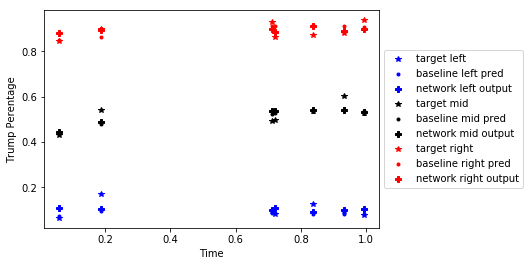

In [28]:
colors = {0: 'b', 1: 'k', 2: 'r'}
labels = {0: 'left', 1: 'mid', 2: 'right'}
times = input_meta_np[:, 5]
for flavor_idx in range(3):
    plt.plot(times, target[:, flavor_idx], colors[flavor_idx] + '*', label='target %s' %labels[flavor_idx])
    plt.plot(times, input_meta_np[:, flavor_idx+6], colors[flavor_idx] + '.', label='baseline %s pred' %labels[flavor_idx])
    plt.plot(times, est[:, flavor_idx], colors[flavor_idx] + 'P', label='network %s output' %labels[flavor_idx])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Trump Perentage")
plt.xlabel("Time")